# Gotland

This notebook runs [GOTM](https://gotm.net/) using the [Gotland deep](https://gotm.net/cases/gotland_deep/) test case. 


In [1]:
import sys
import copy
import numpy as np
import matplotlib.pyplot as plt
sys.path.append("../../../gotmtool")
from gotmtool import *

## Create a model
Create a model with environment file `../../.gotm_env.yaml`, which is created by `gotm_env_init.py`. 

In [2]:
m = Model(name='Gotland', environ='../../.gotm_env.yaml')

Take a look at what are defined in the environment file.

In [3]:
for key in m.environ:
    print('{:>15s}: {}'.format(key, m.environ[key]) )

   gotmdir_code: /Users/qingli/develop/cvmix_in_gotm/gotm/code
   gotmdir_data: /Users/qingli/develop/cvmix_in_gotm/gotm/data
  gotmdir_build: /Users/qingli/develop/cvmix_in_gotm/gotm/build
    gotmdir_exe: /Users/qingli/develop/cvmix_in_gotm/gotm/exe
    gotmdir_run: /Users/qingli/develop/cvmix_in_gotm/gotm/run
 gotmdir_figure: /Users/qingli/develop/cvmix_in_gotm/gotm/figure
   gotmdir_tool: /Users/qingli/develop/cvmix_in_gotm/gotmtool


## Build the model

In [4]:
%%time
m.build()

CPU times: user 2.5 ms, sys: 9.14 ms, total: 11.6 ms
Wall time: 138 ms


## Configuration
Initialize the GOTM configuration

In [5]:
cfg = m.init_config()

Generating default configuration at '/Users/qingli/develop/cvmix_in_gotm/gotm/run/Gotland/gotm.yaml'...
Done!


Update the configuration

In [6]:
# setup
title = 'Gotland Basin'
nlev = 200
cfg['title'] = title
cfg['location']['name'] = 'Station 271'
cfg['location']['latitude'] = 57.3
cfg['location']['longitude'] = 20.0
cfg['location']['depth'] = 250.0
cfg['time']['start'] = '1990-01-01 00:00:00'
cfg['time']['stop']  = '1991-01-01 00:00:00'
cfg['time']['dt']    = 3600.0
cfg['grid']['nlev']  = nlev
cfg['grid']['ddu']   = 2.0

# output
cfg['output']['gotm_out']['title'] = title
cfg['output']['gotm_out']['k1_stop'] = nlev+1
cfg['output']['gotm_out']['k_stop'] = nlev
cfg['output']['gotm_out']['time_unit'] = 'day'
cfg['output']['gotm_out']['time_step'] = 1

# forcing
datadir = m.environ['gotmdir_data']+'/Gotland'
cfg['temperature']['method'] = 2
cfg['temperature']['file'] = datadir+'/t_prof_file.dat'
cfg['salinity']['method'] = 2
cfg['salinity']['file'] = datadir+'/s_prof_file.dat'
cfg['salinity']['relax']['tau'] = 432000.0
cfg['salinity']['relax']['tau_s'] = 432000.0
cfg['salinity']['relax']['tau_b'] = 432000.0
cfg['surface']['fluxes']['method'] = 1
cfg['surface']['meteo']['u10']['method'] = 2
cfg['surface']['meteo']['u10']['file'] = datadir+'/meteo_file.dat'
cfg['surface']['meteo']['u10']['column'] = 1
cfg['surface']['meteo']['u10']['scale_factor'] = 1.23
cfg['surface']['meteo']['v10']['method'] = 2
cfg['surface']['meteo']['v10']['file'] = datadir+'/meteo_file.dat'
cfg['surface']['meteo']['v10']['column'] = 2
cfg['surface']['meteo']['v10']['scale_factor'] = 1.23
cfg['surface']['meteo']['airp']['method'] = 2
cfg['surface']['meteo']['airp']['file'] = datadir+'/meteo_file.dat'
cfg['surface']['meteo']['airp']['column'] = 3
cfg['surface']['meteo']['airp']['scale_factor'] = 100.0
cfg['surface']['meteo']['airt']['method'] = 2
cfg['surface']['meteo']['airt']['file'] = datadir+'/meteo_file.dat'
cfg['surface']['meteo']['airt']['column'] = 4
cfg['surface']['meteo']['airt']['scale_factor'] = 1.0
cfg['surface']['meteo']['hum']['method'] = 2
cfg['surface']['meteo']['hum']['file'] = datadir+'/meteo_file.dat'
cfg['surface']['meteo']['hum']['column'] = 5
cfg['surface']['meteo']['hum']['scale_factor'] = 1.0
cfg['surface']['meteo']['hum']['type'] = 3
cfg['surface']['meteo']['cloud']['method'] = 2
cfg['surface']['meteo']['cloud']['file'] = datadir+'/meteo_file.dat'
cfg['surface']['meteo']['cloud']['column'] = 6
cfg['surface']['meteo']['cloud']['scale_factor'] = 1.0
cfg['surface']['meteo']['swr']['method'] = 3
cfg['surface']['meteo']['precip']['method'] = 2
cfg['surface']['meteo']['precip']['file'] = datadir+'/precip_file.dat'

# water type
cfg['light_extinction']['method'] = 7
cfg['light_extinction']['A']['method'] = 0
cfg['light_extinction']['A']['constant_value'] = 0.4
cfg['light_extinction']['g1']['method'] = 0
cfg['light_extinction']['g1']['constant_value'] = 3
cfg['light_extinction']['g2']['method'] = 0
cfg['light_extinction']['g2']['constant_value'] = 15.7

# EOS 
cfg['eq_state']['mode'] = 2
cfg['eq_state']['method'] = 2

# buoyancy
cfg['buoyancy']['NN_ini'] = 1.0e-4

We want to run the case using two turbulence closure methods:
- The generic length scale (GLS; [Umlauf and Burchard, 2003](https://doi.org/10.1357/002224003322005087)) model in the $k$-$\epsilon$ formulation with the weak-equilibrium stability function by [Canuto et al., 2001](https://doi.org/10.1175/1520-0485(2001)031%3C1413:OTPIOP%3E2.0.CO;2) (C01A).
- The K-profile parameterization (KPP; [Large et al., 1994](https://doi.org/10.1029/94RG01872), [Griffies et al., 2015](https://github.com/CVMix/CVMix-description/raw/master/cvmix.pdf)) with [CVMix](http://cvmix.github.io).


In [7]:
# collect the configurations and the labels of the two runs
cfgs = []
labels = []

In [8]:
cfg['turbulence']['turb_method'] = 3
cfg['turbulence']['tke_method'] = 2
cfg['turbulence']['len_scale_method'] = 10
cfg['turbulence']['scnd']['method'] =  2
cfg['turbulence']['scnd']['scnd_coeff'] =  5
cfg['turbulence']['turb_param']['length_lim'] = 'true'
cfg['turbulence']['turb_param']['compute_c3'] = 'true'
cfg['turbulence']['turb_param']['galp'] = 0.53
cfg['turbulence']['turb_param']['k_min'] = 1.23e-7
cfg['turbulence']['generic']['gen_m'] = 1.5 
cfg['turbulence']['generic']['gen_n'] = -1.0
cfg['turbulence']['generic']['gen_p'] = 3.0 
cfg['turbulence']['generic']['cpsi1'] = 1.44
cfg['turbulence']['generic']['cpsi2'] = 1.92
cfg['turbulence']['generic']['cpsi3minus'] = -0.63
cfg['turbulence']['generic']['cpsi3plus'] = 1.0 
cfg['turbulence']['generic']['sig_kpsi'] = 1.0 
cfg['turbulence']['generic']['sig_psi'] = 1.3
cfgs.append(copy.deepcopy(cfg))
labels.append('GLS-C01A')

In [9]:
cfg['turbulence']['turb_method'] = 100
cfgs.append(copy.deepcopy(cfg))
labels.append('KPP-CVMix')

## Run the model

In [10]:
%%time
sims = m.run_batch(configs=cfgs, labels=labels, nproc=2)

CPU times: user 11.8 ms, sys: 12.9 ms, total: 24.7 ms
Wall time: 2.26 s


## Results

Load the data into an `xarray.Dataset`.

(-100, 0)

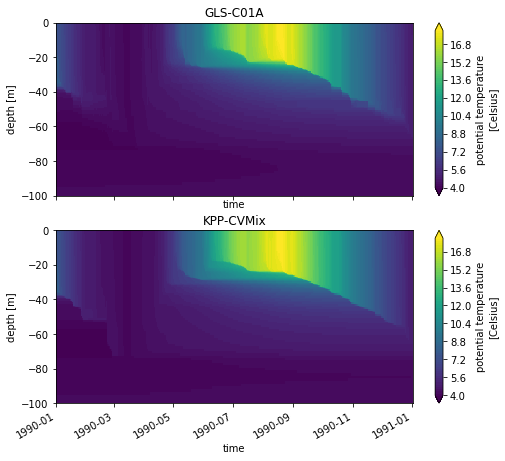

In [11]:
fig, axarr = plt.subplots(2, sharex='col')
fig.set_size_inches(8, 7)
data0 = sims[0].load_data()
levels = np.linspace(4, 18, 71)
data0.temp.plot(ax=axarr[0], levels=levels)
axarr[0].set_title(labels[0])
axarr[0].set_ylim([-100, 0])
data1 = sims[1].load_data()
data1.temp.plot(ax=axarr[1], levels=levels)
axarr[1].set_title(labels[1])
axarr[1].set_ylim([-100, 0])